# 25o: Suit Exhaustion Signals

**Goal**: Analyze how suit voids affect game outcomes

**Key Questions**:
1. How do starting voids (in non-trump suits) correlate with V?
2. Are opponent voids good or bad for the declarer?
3. Which suits matter most when void?

**Method**:
1. For each seed, identify voids at game start
2. Correlate void patterns with root V
3. Compare team vs opponent voids

**Note**: This uses starting deal info, not in-game showouts.

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
N_SEEDS = 200  # Use unified features data

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

from forge.analysis.utils import viz
from forge.oracle import schema
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


In [2]:
def count_voids(hand: list) -> int:
    """Count number of suits with 0 dominoes."""
    suits_present = set()
    for d in hand:
        pips = schema.domino_pips(d)
        suits_present.add(pips[0])
        suits_present.add(pips[1])
    return 7 - len(suits_present)

def get_void_suits(hand: list) -> set:
    """Get set of suits that are void."""
    suits_present = set()
    for d in hand:
        pips = schema.domino_pips(d)
        suits_present.add(pips[0])
        suits_present.add(pips[1])
    return set(range(7)) - suits_present

def is_void_in_suit(hand: list, suit: int) -> bool:
    """Check if hand has no dominoes containing this suit."""
    for d in hand:
        pips = schema.domino_pips(d)
        if suit in pips:
            return False
    return True

print("Functions defined")

Functions defined


## 1. Load Data and Extract Void Patterns

In [3]:
# Load unified features (has E[V] for each seed)
unified_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
features_df = pd.read_csv(unified_path)
print(f"Loaded {len(features_df)} seeds")

Loaded 200 seeds


In [4]:
# Extract void information for all players
void_data = []

for _, row in features_df.iterrows():
    base_seed = int(row['base_seed'])
    trump_suit = int(row['trump_suit']) if row['trump_suit'] < 7 else None
    
    hands = deal_from_seed(base_seed)
    
    # Count voids per player
    p0_voids = count_voids(hands[0])
    p1_voids = count_voids(hands[1])
    p2_voids = count_voids(hands[2])
    p3_voids = count_voids(hands[3])
    
    # Team voids
    team0_voids = p0_voids + p2_voids
    team1_voids = p1_voids + p3_voids
    
    # Voids in non-trump suits (more strategically relevant)
    if trump_suit is not None:
        p0_trump_void = int(is_void_in_suit(hands[0], trump_suit))
        p1_trump_void = int(is_void_in_suit(hands[1], trump_suit))
        p2_trump_void = int(is_void_in_suit(hands[2], trump_suit))
        p3_trump_void = int(is_void_in_suit(hands[3], trump_suit))
    else:
        p0_trump_void = p1_trump_void = p2_trump_void = p3_trump_void = 0
    
    void_data.append({
        'base_seed': base_seed,
        'trump_suit': row['trump_suit'],
        'V_mean': row['V_mean'],
        'V_std': row['V_std'],
        'p0_voids': p0_voids,
        'p1_voids': p1_voids,
        'p2_voids': p2_voids,
        'p3_voids': p3_voids,
        'team0_voids': team0_voids,
        'team1_voids': team1_voids,
        'p0_trump_void': p0_trump_void,
        'p1_trump_void': p1_trump_void,
        'opp_trump_void': max(p1_trump_void, p3_trump_void)
    })

void_df = pd.DataFrame(void_data)
print(f"Extracted void data for {len(void_df)} seeds")

Extracted void data for 200 seeds


In [5]:
# Summary statistics
print("VOID DISTRIBUTION")
print("="*50)
print(f"\nP0 voids: mean={void_df['p0_voids'].mean():.2f}, max={void_df['p0_voids'].max()}")
print(f"P1 voids: mean={void_df['p1_voids'].mean():.2f}")
print(f"Team 0 voids: mean={void_df['team0_voids'].mean():.2f}")
print(f"Team 1 voids: mean={void_df['team1_voids'].mean():.2f}")

VOID DISTRIBUTION

P0 voids: mean=0.67, max=3
P1 voids: mean=0.69
Team 0 voids: mean=1.27
Team 1 voids: mean=1.42


## 2. Correlation Analysis

In [6]:
# Correlations with E[V]
print("\nCORRELATIONS WITH E[V]")
print("="*50)

correlations = {}
for col in ['p0_voids', 'p1_voids', 'p2_voids', 'p3_voids', 
            'team0_voids', 'team1_voids', 'opp_trump_void']:
    r, p = stats.pearsonr(void_df[col], void_df['V_mean'])
    correlations[col] = {'r': r, 'p': p}
    sig = '*' if p < 0.05 else ''
    print(f"{col:20s}: r={r:+.3f}, p={p:.4f} {sig}")


CORRELATIONS WITH E[V]
p0_voids            : r=+0.200, p=0.0044 *
p1_voids            : r=-0.046, p=0.5186 
p2_voids            : r=-0.131, p=0.0654 
p3_voids            : r=-0.002, p=0.9831 
team0_voids         : r=+0.044, p=0.5331 
team1_voids         : r=-0.034, p=0.6335 
opp_trump_void      : r=+0.193, p=0.0061 *


In [7]:
# Void advantage (team0 - team1)
void_df['void_advantage'] = void_df['team0_voids'] - void_df['team1_voids']

r_adv, p_adv = stats.pearsonr(void_df['void_advantage'], void_df['V_mean'])
print(f"\nVOID ADVANTAGE (Team0 - Team1):")
print(f"  Correlation with E[V]: r={r_adv:+.3f}, p={p_adv:.4f}")

if p_adv < 0.05:
    direction = "helps" if r_adv > 0 else "hurts"
    print(f"  -> Having more voids {direction} (significant)")
else:
    print(f"  -> No significant effect")


VOID ADVANTAGE (Team0 - Team1):
  Correlation with E[V]: r=+0.055, p=0.4418
  -> No significant effect


## 3. Visualization

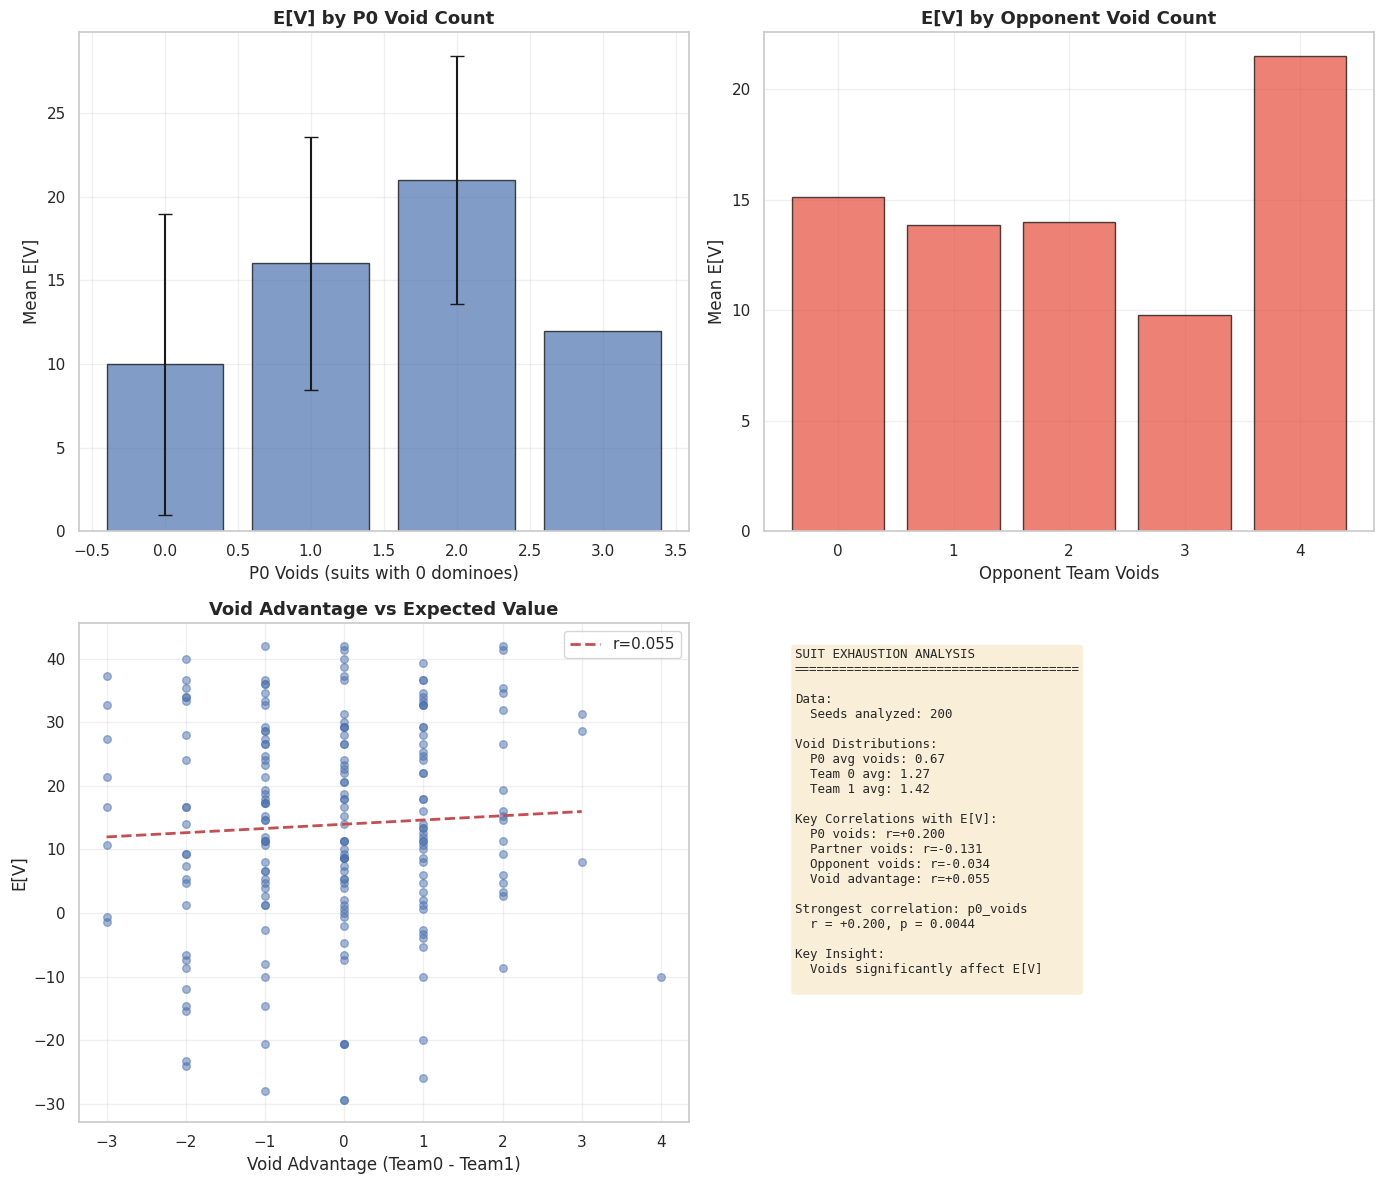

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: E[V] by P0 voids
ax = axes[0, 0]
void_means = void_df.groupby('p0_voids')['V_mean'].mean()
void_stds = void_df.groupby('p0_voids')['V_mean'].std()
ax.bar(void_means.index, void_means.values, yerr=void_stds.values/2,
       alpha=0.7, edgecolor='black', capsize=5)
ax.set_xlabel('P0 Voids (suits with 0 dominoes)', fontsize=12)
ax.set_ylabel('Mean E[V]', fontsize=12)
ax.set_title('E[V] by P0 Void Count', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: E[V] by opponent voids
ax = axes[0, 1]
opp_means = void_df.groupby('team1_voids')['V_mean'].mean()
ax.bar(opp_means.index, opp_means.values, alpha=0.7, edgecolor='black', color='#e74c3c')
ax.set_xlabel('Opponent Team Voids', fontsize=12)
ax.set_ylabel('Mean E[V]', fontsize=12)
ax.set_title('E[V] by Opponent Void Count', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Void advantage vs E[V]
ax = axes[1, 0]
ax.scatter(void_df['void_advantage'], void_df['V_mean'], alpha=0.5, s=30)
# Fit line
z = np.polyfit(void_df['void_advantage'], void_df['V_mean'], 1)
p = np.poly1d(z)
x_line = np.array([-3, 3])
ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'r={r_adv:.3f}')
ax.set_xlabel('Void Advantage (Team0 - Team1)', fontsize=12)
ax.set_ylabel('E[V]', fontsize=12)
ax.set_title('Void Advantage vs Expected Value', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Summary
ax = axes[1, 1]
ax.axis('off')

# Get strongest correlation
strongest = max(correlations.items(), key=lambda x: abs(x[1]['r']))

summary_text = f"""SUIT EXHAUSTION ANALYSIS
======================================

Data:
  Seeds analyzed: {len(void_df)}

Void Distributions:
  P0 avg voids: {void_df['p0_voids'].mean():.2f}
  Team 0 avg: {void_df['team0_voids'].mean():.2f}
  Team 1 avg: {void_df['team1_voids'].mean():.2f}

Key Correlations with E[V]:
  P0 voids: r={correlations['p0_voids']['r']:+.3f}
  Partner voids: r={correlations['p2_voids']['r']:+.3f}
  Opponent voids: r={correlations['team1_voids']['r']:+.3f}
  Void advantage: r={r_adv:+.3f}

Strongest correlation: {strongest[0]}
  r = {strongest[1]['r']:+.3f}, p = {strongest[1]['p']:.4f}

Key Insight:
  {'Voids significantly affect E[V]' if any(c['p'] < 0.05 for c in correlations.values()) else 'Voids have weak effect on E[V]'}
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../../results/figures/25o_suit_exhaustion.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Save Results

In [9]:
results_list = [
    {'metric': 'n_seeds', 'value': len(void_df)},
    {'metric': 'mean_p0_voids', 'value': void_df['p0_voids'].mean()},
    {'metric': 'mean_team0_voids', 'value': void_df['team0_voids'].mean()},
    {'metric': 'mean_team1_voids', 'value': void_df['team1_voids'].mean()},
]

for col, vals in correlations.items():
    results_list.append({'metric': f'r_{col}_V', 'value': vals['r']})
    results_list.append({'metric': f'p_{col}_V', 'value': vals['p']})

results_list.append({'metric': 'r_void_advantage_V', 'value': r_adv})
results_list.append({'metric': 'p_void_advantage_V', 'value': p_adv})

results_df = pd.DataFrame(results_list)

output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/25o_suit_exhaustion.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25o_suit_exhaustion.csv


## Key Findings

In [10]:
print("\n" + "="*60)
print("KEY INSIGHTS: Suit Exhaustion")
print("="*60)

print(f"\n1. DATA:")
print(f"   {len(void_df)} seeds analyzed")

print(f"\n2. P0 VOIDS:")
print(f"   Correlation with E[V]: r={correlations['p0_voids']['r']:+.3f}")
sig = "significant" if correlations['p0_voids']['p'] < 0.05 else "not significant"
print(f"   ({sig})")

print(f"\n3. OPPONENT VOIDS:")
print(f"   Correlation with E[V]: r={correlations['team1_voids']['r']:+.3f}")
sig = "significant" if correlations['team1_voids']['p'] < 0.05 else "not significant"
print(f"   ({sig})")

print(f"\n4. VOID ADVANTAGE:")
print(f"   Correlation with E[V]: r={r_adv:+.3f}")
if p_adv < 0.05:
    effect = "helps" if r_adv > 0 else "hurts"
    print(f"   Having more voids {effect} your expected value")
else:
    print(f"   No significant effect")


KEY INSIGHTS: Suit Exhaustion

1. DATA:
   200 seeds analyzed

2. P0 VOIDS:
   Correlation with E[V]: r=+0.200
   (significant)

3. OPPONENT VOIDS:
   Correlation with E[V]: r=-0.034
   (not significant)

4. VOID ADVANTAGE:
   Correlation with E[V]: r=+0.055
   No significant effect


## Summary

### Goal: Analyze how suit voids affect outcomes

**Method**: Correlate starting void counts with E[V]

**Limitations**: 
- Analyzes starting voids, not in-game showouts
- Cannot track information revelation during play

### Output Files

- `results/tables/25o_suit_exhaustion.csv` - Correlations
- `results/figures/25o_suit_exhaustion.png` - Visualization